# Electricity Customer에 대해서 수행

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_forecasting.metrics import SMAPE,RMSE,MAE
from captum.attr import IntegratedGradients,NoiseTunnel

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def MSE(pred,target):
    return torch.mean((pred-target)**2,dim = 0) # reduction까지 취해줌

## 1. 모델 구성하기
* 시간단위의 데이터로써 24x30 =720 즉 30일을 바라봄

In [3]:
use_col = ['volumn']
data = pd.read_csv('../../TrafficData/1-Copy1.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
sequence_length = 720
pred_len = 1

<AxesSubplot: >

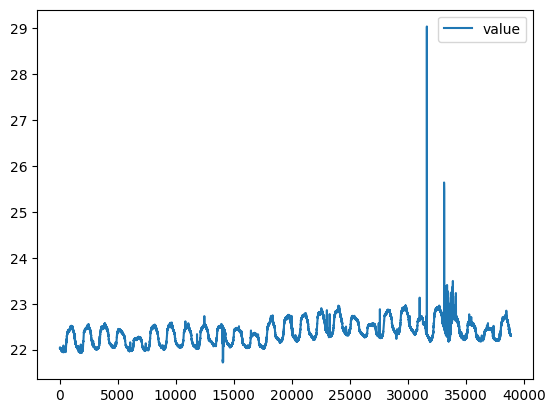

In [4]:
data.plot()

In [5]:
from torch import FloatTensor as FloatTensor

In [6]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(len(x)-sequence_length):
        seq_list.append(x.iloc[i:i+sequence_length].values)
        target_list.append(x.iloc[i+sequence_length].values)

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [7]:
split = 24*7 # 24시간 x 7로써 1주일을 테스트셋으로 만듦

In [8]:
seed = 42

In [9]:
device = torch.device("cuda:0")

In [10]:
class Model(nn.Module):
    def __init__(self,train_index):
        super().__init__()
        self.seq_len = len(train_index)
        self.pred_len = 1
        self.train_index = train_index
        self.first_layer = nn.Linear(self.seq_len,self.pred_len)
        self.first_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
    def forward(self,x):
        return self.first_layer(x[:,:,self.train_index]) 

# 3. Train-Validation set으로 쪼개기

In [11]:
data

,value
0,22.041608
1,22.048000
2,22.047176
3,22.042408
4,22.049328
...,...
38875,22.316160
38876,22.305744
38877,22.318160
38878,22.310040


* 8761개 중 일주일치 데이터인 168개의 데이터를 Test Set
* 8761 중 0.2의 비율인 1752개는 validation set
* 8761개 중 0.8의 비율인 7009개는 train set

In [12]:
val_num = 1752

In [13]:
train = data.iloc[:-split-val_num]
val = data.iloc[-split-val_num:-split]
x_train,y_train = seq_data(train, sequence_length = sequence_length, pred_len = pred_len)
x_val,y_val = seq_data(val, sequence_length = sequence_length, pred_len = pred_len)
train_dataset = TensorDataset(x_train,y_train)
val_dataset = TensorDataset(x_val,y_val)
training = DataLoader(train_dataset,batch_size=64)
validation = DataLoader(val_dataset,batch_size=64)

/tmp/ipykernel_874849/2654461304.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [14]:
next(iter(validation))[0].size()

torch.Size([64, 1, 720])

### 위와 같은 방식으로 validation-set에 대해서 기여도를 구하면 될 것이다.
-> 모든 batch의 각 sample에 대해서 Ig를 통한 attribution을 구해서 모든 batch에 걸쳐서 더한후 그것을 평균시킨다.<br>
-> 결과적으로 모든 validation set에 대한 attribution을 평균한다.

In [15]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
train_index = np.arange(sequence_length)
model = Model(train_index).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
num_epochs = 100
n= len(training)

### 기본 모델 training

In [16]:
import copy

In [17]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss=np.inf
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
        
        outputs = outputs.view(-1,1)
        labels = labels.view(-1,1)
        
        # defining loss
        loss = MSE(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

Epoch [1]/[100] running accumulative loss across all batches: 5.621
changed
changed
changed
changed
changed
Epoch [21]/[100] running accumulative loss across all batches: 4.210
Epoch [41]/[100] running accumulative loss across all batches: 8.172
Epoch [61]/[100] running accumulative loss across all batches: 7.439
Epoch [81]/[100] running accumulative loss across all batches: 7.069


### validation set에 대해서 attribution 구하기

In [18]:
n = len(validation)
n

17

In [19]:
cnt = 0
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
nt_ig_attr_score = torch.zeros((1,sequence_length))
for val in validation:
    temp_n = val[0].size(0)
    temp = nt_ig.attribute(val[0]).sum(axis = 0) # axis=0으로 batch axis를 기준으로 다 더했음
    nt_ig_attr_score = nt_ig_attr_score.to(device)+temp
    cnt = cnt + temp_n
nt_ig_attr_score = nt_ig_attr_score/cnt
nt_ig_attr_score = nt_ig_attr_score.cpu().numpy().reshape(-1)

In [20]:
len(nt_ig_attr_score)

720

<AxesSubplot: >

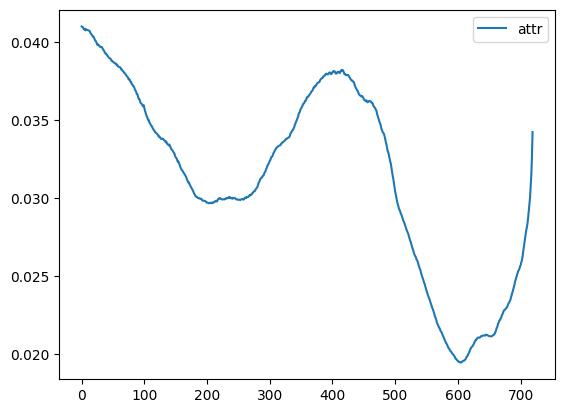

In [21]:
attr_df = pd.DataFrame({'attr':nt_ig_attr_score})
attr_df.plot()

### &rightarrow; 최근데이터가 매우강조 되는것을 확인할 수 있다.

#### scaling

* 표준화는 데이터가 정규분포를 따른다고 가정해야지 1sigma와 -1sigma에 68%정도의 데이터가 모여있음
* 데이터를 z-score로 변환(즉, 데이터를 표준화 또는 정규화)한다고 해서 데이터가 정규분포가 되는 것은 아니다. 단지 비교를 목적으로 데이터를 표준정규분포와 같은 척도로 만드는 것 뿐이다.
* 결과적으로 원래 정규분포의 형태였던 분포를 공통척도(평균은 0 표준편차는 1)로 바꾸는 것

https://hleecaster.com/ml-normalization-concept/

<AxesSubplot: >

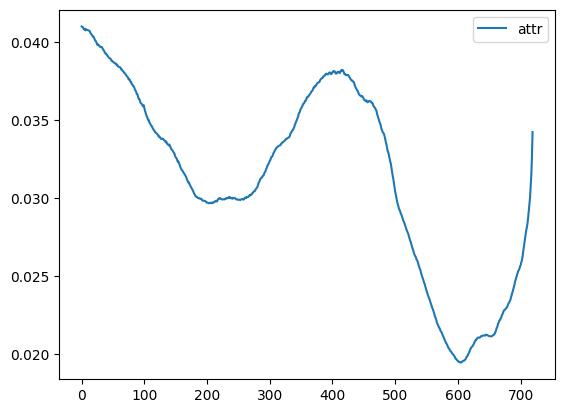

In [22]:
attr_df = attr_df.abs()
attr_df.plot()

## Outlier정의

In [23]:
IQR = 1.5*(attr_df.quantile(0.75)-attr_df.quantile(0.25))
outlier_max = attr_df.quantile(0.75)+IQR
outlier_min = attr_df.quantile(0.25)-IQR
candidate_attr = attr_df[(attr_df>=outlier_min) & (attr_df<=outlier_max)]
candidate_attr = candidate_attr.dropna()
candidate_attr

,attr
0,0.040976
1,0.040956
2,0.040921
3,0.040840
4,0.040787
...,...
715,0.030023
716,0.030683
717,0.031457
718,0.032580


In [24]:
outlier_max

attr    0.05046
dtype: float64

In [25]:
outlier_min

attr    0.013069
dtype: float64

<AxesSubplot: >

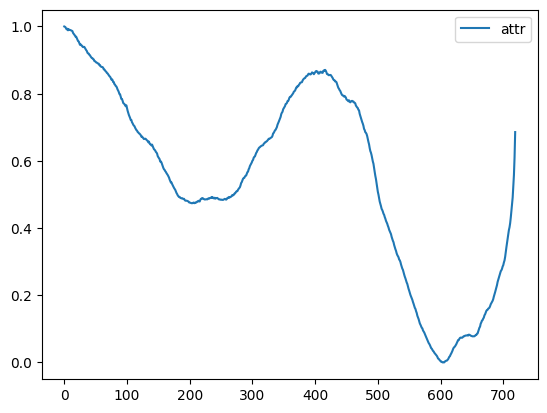

In [26]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
scaler.fit(candidate_attr.values)
m_attr_df = scaler.transform(attr_df.values)
m_attr_df = pd.DataFrame({"attr":m_attr_df.reshape(-1)})
# attr_df = attr_df.abs()
# attr_std = attr_df.std().item()
# attr_min = attr_df.min().item()
m_attr_df.plot()

In [27]:
m_attr_df.describe()

,attr
count,720.000000
mean,0.545847
std,0.283249
min,0.000000
25%,0.354603
50%,0.578479
75%,0.789099
max,1.000000


## 0과 1사이의 분포 확인하기

In [28]:
m_attr_df[(m_attr_df>=0) & (m_attr_df<=1)].dropna()

,attr
0,1.000000
1,0.999091
2,0.997473
3,0.993701
4,0.991219
...,...
715,0.490926
716,0.521560
717,0.557581
718,0.609748


* outlier를 제외하면 들어와있음을 확인할 수 있다.

<AxesSubplot: >

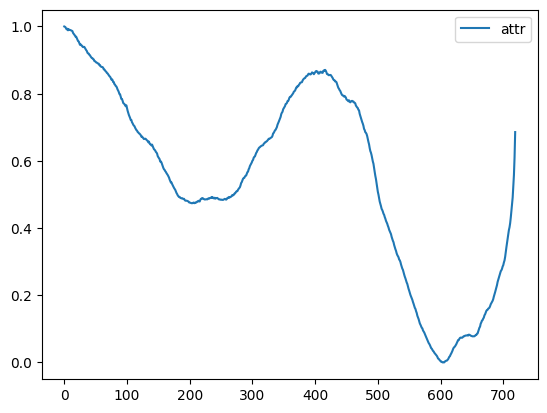

In [29]:
m_attr_df[(m_attr_df>=0) & (m_attr_df<=1)].dropna().plot()

### MinMaxScaler와 비교

<AxesSubplot: >

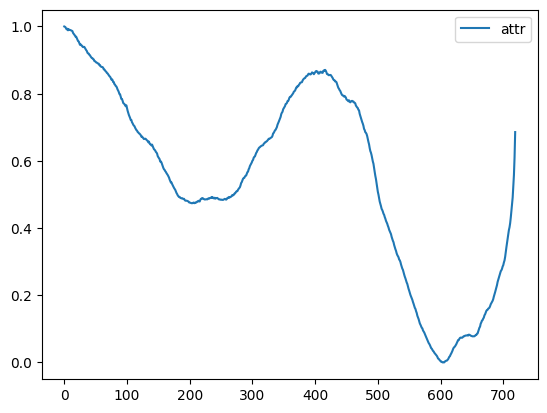

In [30]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
attr_df = scaler.fit_transform(attr_df.values)
attr_df = pd.DataFrame({"attr":attr_df.reshape(-1)})
# attr_df = attr_df.abs()
# attr_std = attr_df.std().item()
# attr_min = attr_df.min().item()
attr_df.plot()

#### train_index구하기

In [31]:
index_list = []

for hyper_para in np.arange(0.00,1.00,0.01):
    append_idx = list(m_attr_df[(m_attr_df['attr']>=hyper_para)].index)
    index_list.append(append_idx)
len(index_list) # train_index의 리스트

100

In [32]:
len_list=[]
for i in range(100):
    len_list.append(len(index_list[i]))


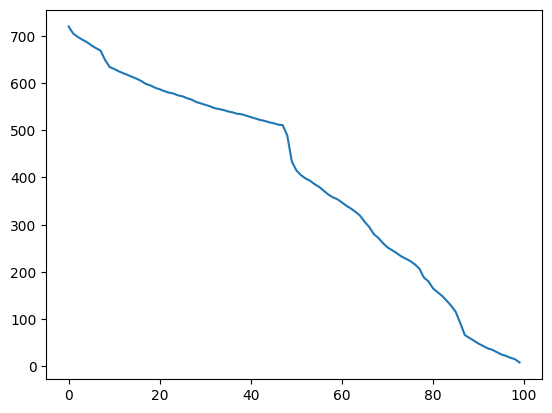

In [33]:
plt.plot(np.arange(100),len_list) # 포함되는 time_index의 갯수

In [34]:
### 원래 난수가 선언된 위치
m = len(validation)
n = len(training)
cnt = 0
mse_out_list = []
mae_out_list = []
smape_out_list = []
rmse_out_list = []
num_epochs = 100
for idx in index_list: #0.01~1.00 100개의 index에 대해서 수행
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
    train_idx = idx
    minimal_loss=np.inf
    model = Model(train_idx).to(device) # 모델 초기화
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
    result = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in training:
            # forward pass
            inputs = inputs
            
            outputs = model(inputs)
            outputs = outputs.view(-1,1)
            labels = labels.view(-1,1)            
            # defining loss
            loss = MSE(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch == 99:    
            print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
        
        if (running_loss/n)*100<minimal_loss:
            best_model = copy.deepcopy(model)
            minimal_loss = (running_loss/n)*100
            print("changed")

    model = best_model
    cnt+=1
    # 모델 Fully-Training 완료
    
    pred = torch.FloatTensor().to(device)
    val_target = torch.FloatTensor().to(device)
    for val_x,val_y in validation:
        tmp_pred = model(val_x)
        pred = torch.concat([pred,tmp_pred], dim=0)
        val_target = torch.concat([val_target,val_y],dim = 0)
    pred = pred.view(-1,1)
    val_target = val_target.view(-1,1)
    result = MSE(pred,val_target).item()
    mse_out_list.append(result)
    mae_out_list.append(MAE()(pred,val_target).item())
    rmse_out_list.append(RMSE()(pred,val_target).item())
    smape_out_list.append(SMAPE()(pred,val_target).item()*100)

changed
changed
changed
changed
changed
0번째 모델 Training 완료 마지막 Epoch loss:7.868690156058378
changed
changed
changed
changed
changed
1번째 모델 Training 완료 마지막 Epoch loss:7.457307053553729
changed
changed
changed
changed
changed
2번째 모델 Training 완료 마지막 Epoch loss:8.702195872381457
changed
changed
changed
changed
3번째 모델 Training 완료 마지막 Epoch loss:8.033490142569635
changed
changed
changed
changed
changed
4번째 모델 Training 완료 마지막 Epoch loss:7.751057839369717
changed
changed
changed
changed
changed
changed
5번째 모델 Training 완료 마지막 Epoch loss:7.467608283026673
changed
changed
changed
changed
changed
changed
changed
changed
changed
6번째 모델 Training 완료 마지막 Epoch loss:7.304770368844521
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
7번째 모델 Training 완료 마지막 Epoch loss:4.328991089099763
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed


changed
changed
changed
changed
35번째 모델 Training 완료 마지막 Epoch loss:3.9544623216479233
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
36번째 모델 Training 완료 마지막 Epoch loss:4.028398689809651
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
37번째 모델 Training 완료 마지막 Epoch loss:4.038460353012932
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
38번째 모델 Training 완료 마지막 

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
57번째 모델 Training 완료 마지막 Epoch loss:53.99400916760414
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
58번째 모델 Training 완료 마지막 Epoch loss:256.57839688597284
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
59번째 모델 Training 완료 마지막 Epoch loss:205.96482019944978
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
86번째 모델 Training 완료 마지막 Epoch loss:24.597407185867375
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
ch

In [35]:
val_y # 다음 예측 타겟값

tensor([[[22.4451]],

        [[22.4416]],

        [[22.4348]],

        [[22.4546]],

        [[22.4543]],

        [[22.4511]],

        [[22.4518]],

        [[22.4494]]], device='cuda:0')

In [36]:
val_x # 예측 하는 값

tensor([[[22.3467, 22.3506, 22.3482,  ..., 22.4550, 22.4513, 22.4471]],

        [[22.3506, 22.3482, 22.3562,  ..., 22.4513, 22.4471, 22.4451]],

        [[22.3482, 22.3562, 22.3541,  ..., 22.4471, 22.4451, 22.4416]],

        ...,

        [[22.3473, 22.3680, 22.3596,  ..., 22.4348, 22.4546, 22.4543]],

        [[22.3680, 22.3596, 22.3599,  ..., 22.4546, 22.4543, 22.4511]],

        [[22.3596, 22.3599, 22.3639,  ..., 22.4543, 22.4511, 22.4518]]],
       device='cuda:0')

In [37]:
result/68

0.0025348275461617637

In [38]:
val_x.size()

torch.Size([8, 1, 720])

        out
3  0.035054


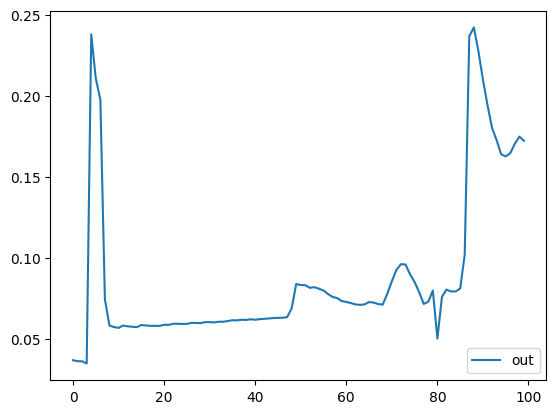

In [39]:
out_df = pd.DataFrame({"out":mse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [40]:
out_df

,out
0,0.037061
1,0.036480
2,0.036383
3,0.035054
4,0.238020
...,...
95,0.162769
96,0.164708
97,0.170538
98,0.174977


        out
3  0.172434


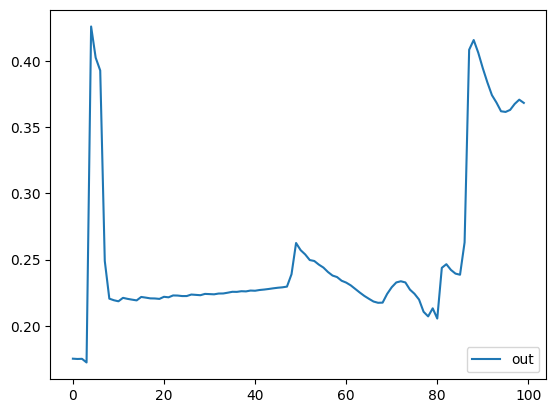

In [41]:
out_df = pd.DataFrame({"out":mae_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [42]:
out_df

,out
0,0.175295
1,0.175077
2,0.175191
3,0.172434
4,0.425937
...,...
95,0.361464
96,0.363002
97,0.367507
98,0.370710


        out
3  0.766675


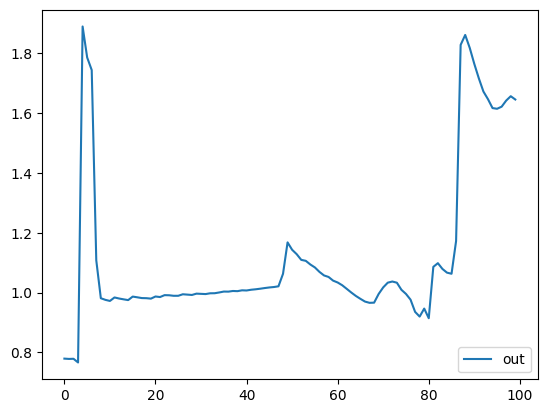

In [43]:
out_df = pd.DataFrame({"out":smape_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [44]:
out_df

,out
0,0.779529
1,0.778517
2,0.779003
3,0.766675
4,1.888410
...,...
95,1.613664
96,1.620634
97,1.641059
98,1.655599


        out
3  0.187228


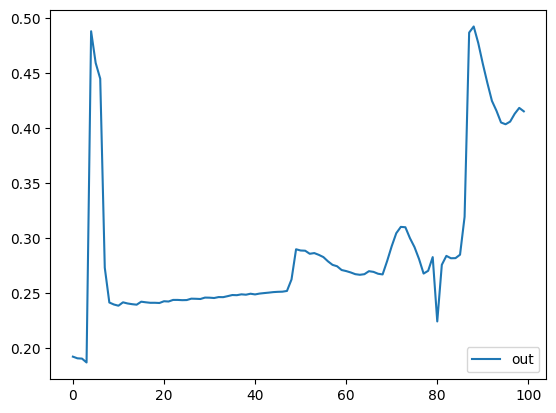

In [45]:
out_df = pd.DataFrame({"out":rmse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [46]:
out_df

,out
0,0.192513
1,0.190997
2,0.190744
3,0.187228
4,0.487873
...,...
95,0.403446
96,0.405842
97,0.412962
98,0.418303


In [47]:
attr_df.describe()

,attr
count,720.000000
mean,0.545847
std,0.283249
min,0.000000
25%,0.354603
50%,0.578479
75%,0.789099
max,1.000000
